# Differential geometry analyses on hematopoiesis dataset

In this tutorial, we will guide you to
- visualize vector field pseudotime
- build graphs, compute divergence and potential with `dynamo`
- show a regulatory network governing the Bas lineage's dual origins
- cell-wise analyses of SPI1-GATA1 network motif
- visualize topography with computed fixed points and manually filtered fixed points

Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns

dyn.dynamo_logger.main_silence()


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
adata_labeling = dyn.sample_data.hematopoiesis()


take a glance at what is in `adata` object. All observations, embedding layers and other data in `adata` are computed within `dynamo`. Please refer to other dynamo tutorials regarding how to obtain these values from metadata and raw new/total and (or) raw spliced/unspliced gene expression values.

In [3]:
adata_labeling


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

## Schematic of leveraging differential geometry 
- ranking genes (using either raw or absolute values) across all cells or in each cell group/state
- gene set enrichment, network construction, and visualization
- identifying top toggle-switch pairs driving cell fate bifurcations

![fig5_A](images/fig5_A.png)

## Vector field pseudotime

In this section, we will show how to visualize vector field pseudotime with `dynamo`. The vector field pseudotime is calculated based on the velocity transition matrix.

**Define a colormap we will use later**

In [4]:
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}


**Initialize a dataframe object we will use to plot with visualization packages such as `sns`**

In [5]:
valid_cell_type = ["HSC", "MEP-like", "Meg", "Ery", "Bas"]
valid_indices = adata_labeling.obs["cell_type"].isin(valid_cell_type)
df = adata_labeling[valid_indices].obs[["pca_ddhodge_potential", "umap_ddhodge_potential", "cell_type"]]
df["cell_type"] = list(df["cell_type"])

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_25538/819458431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cell_type"] = list(df["cell_type"])


### Building a graph, computing divergence and potential with `graph_operators` in `dynamo`

In [6]:
from dynamo.tools.graph_operators import build_graph, div, potential
g = build_graph(adata_labeling.obsp["cosine_transition_matrix"])
ddhodge_div = div(g)
potential_cosine = potential(g, -ddhodge_div)
adata_labeling.obs["cosine_potential"] = potential_cosine

df["cosine"] = potential_cosine[valid_indices]


Compute `potential_fp` and store in the dataframe object `df` we created above. Note that `fp` stands for `fokkerplanck`. Please refer to the `dynamo` cell paper for more details on the related methods.

Text(0.5, 6.44444444444443, 'vector field pseudotime')

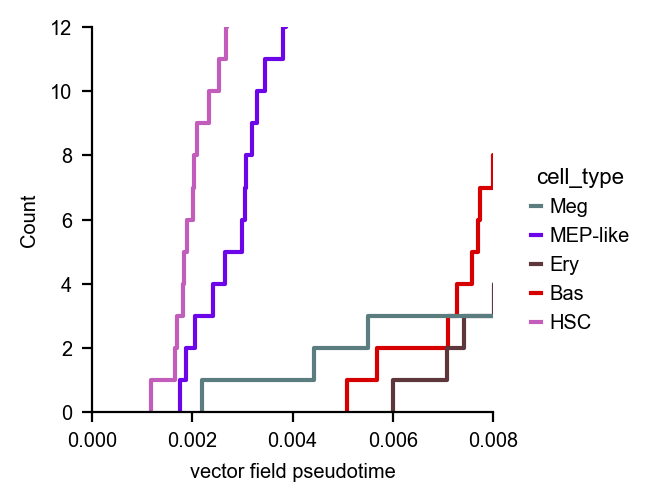

In [7]:
g = build_graph(adata_labeling.obsp["fp_transition_rate"])

ddhodge_div = div(g)
potential_fp = potential(g, -ddhodge_div)
df["fp"] = potential_fp[valid_indices]

sns.displot(
    data=df,
    x="cosine",
    hue="cell_type",
    kind="ecdf",
    stat="count",
    palette=dynamo_color_dict,
    height=2.5,
    aspect=95.5 / 88.8,
)
plt.xlim(0.0, 0.008)
plt.ylim(0, 12)

plt.xlabel("vector field pseudotime")


With the visualization results, we can observe that egakaryocytes appear earliest among the Meg, Ery, and Bas lineages. 

## Molecular mechanisms underlying the early appearance of the Meg lineage

In this section, we will show:
- Self- activation of FLI1
- Repression of KLF1 by FLI1
- FLI1 represses KLF1
- Schematic summarizing the interactions involving FLI1 and KLF1.

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 140292.91it/s]
/Users/random/dynamo-release/dynamo/plot/vector_calculus.py:658: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


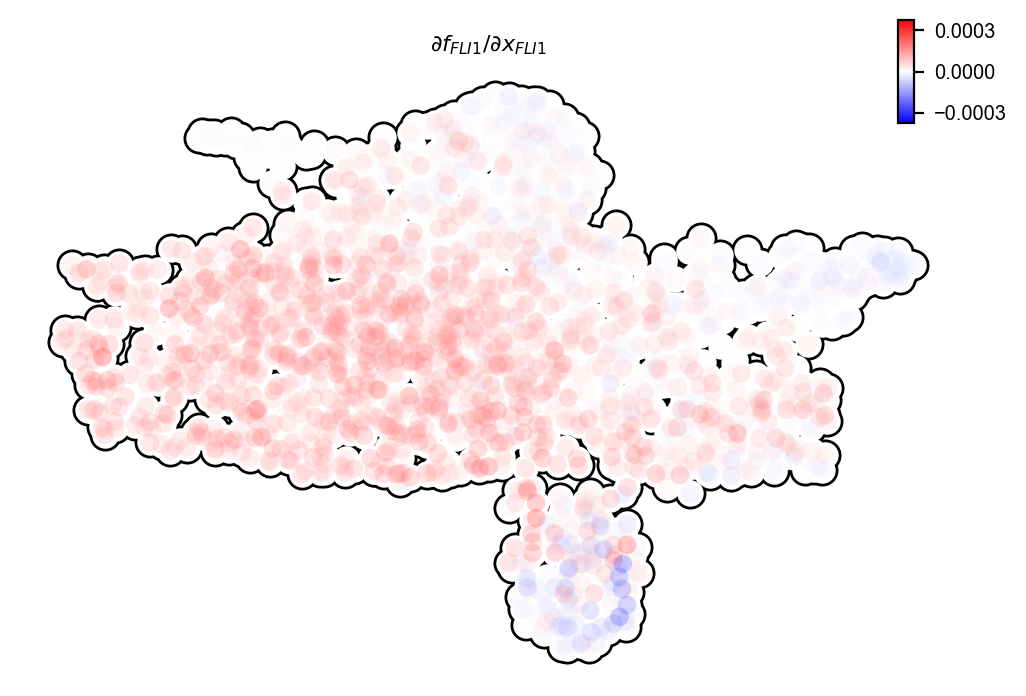

In [8]:
Meg_genes = ["FLI1", "KLF1"]
dyn.vf.jacobian(adata_labeling, regulators=Meg_genes, effectors=Meg_genes)
dyn.pl.jacobian(
    adata_labeling,
    regulators="FLI1",
    basis="umap",
)


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/random/dynamo-release/dynamo/plot/vector_calculus.py:658: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


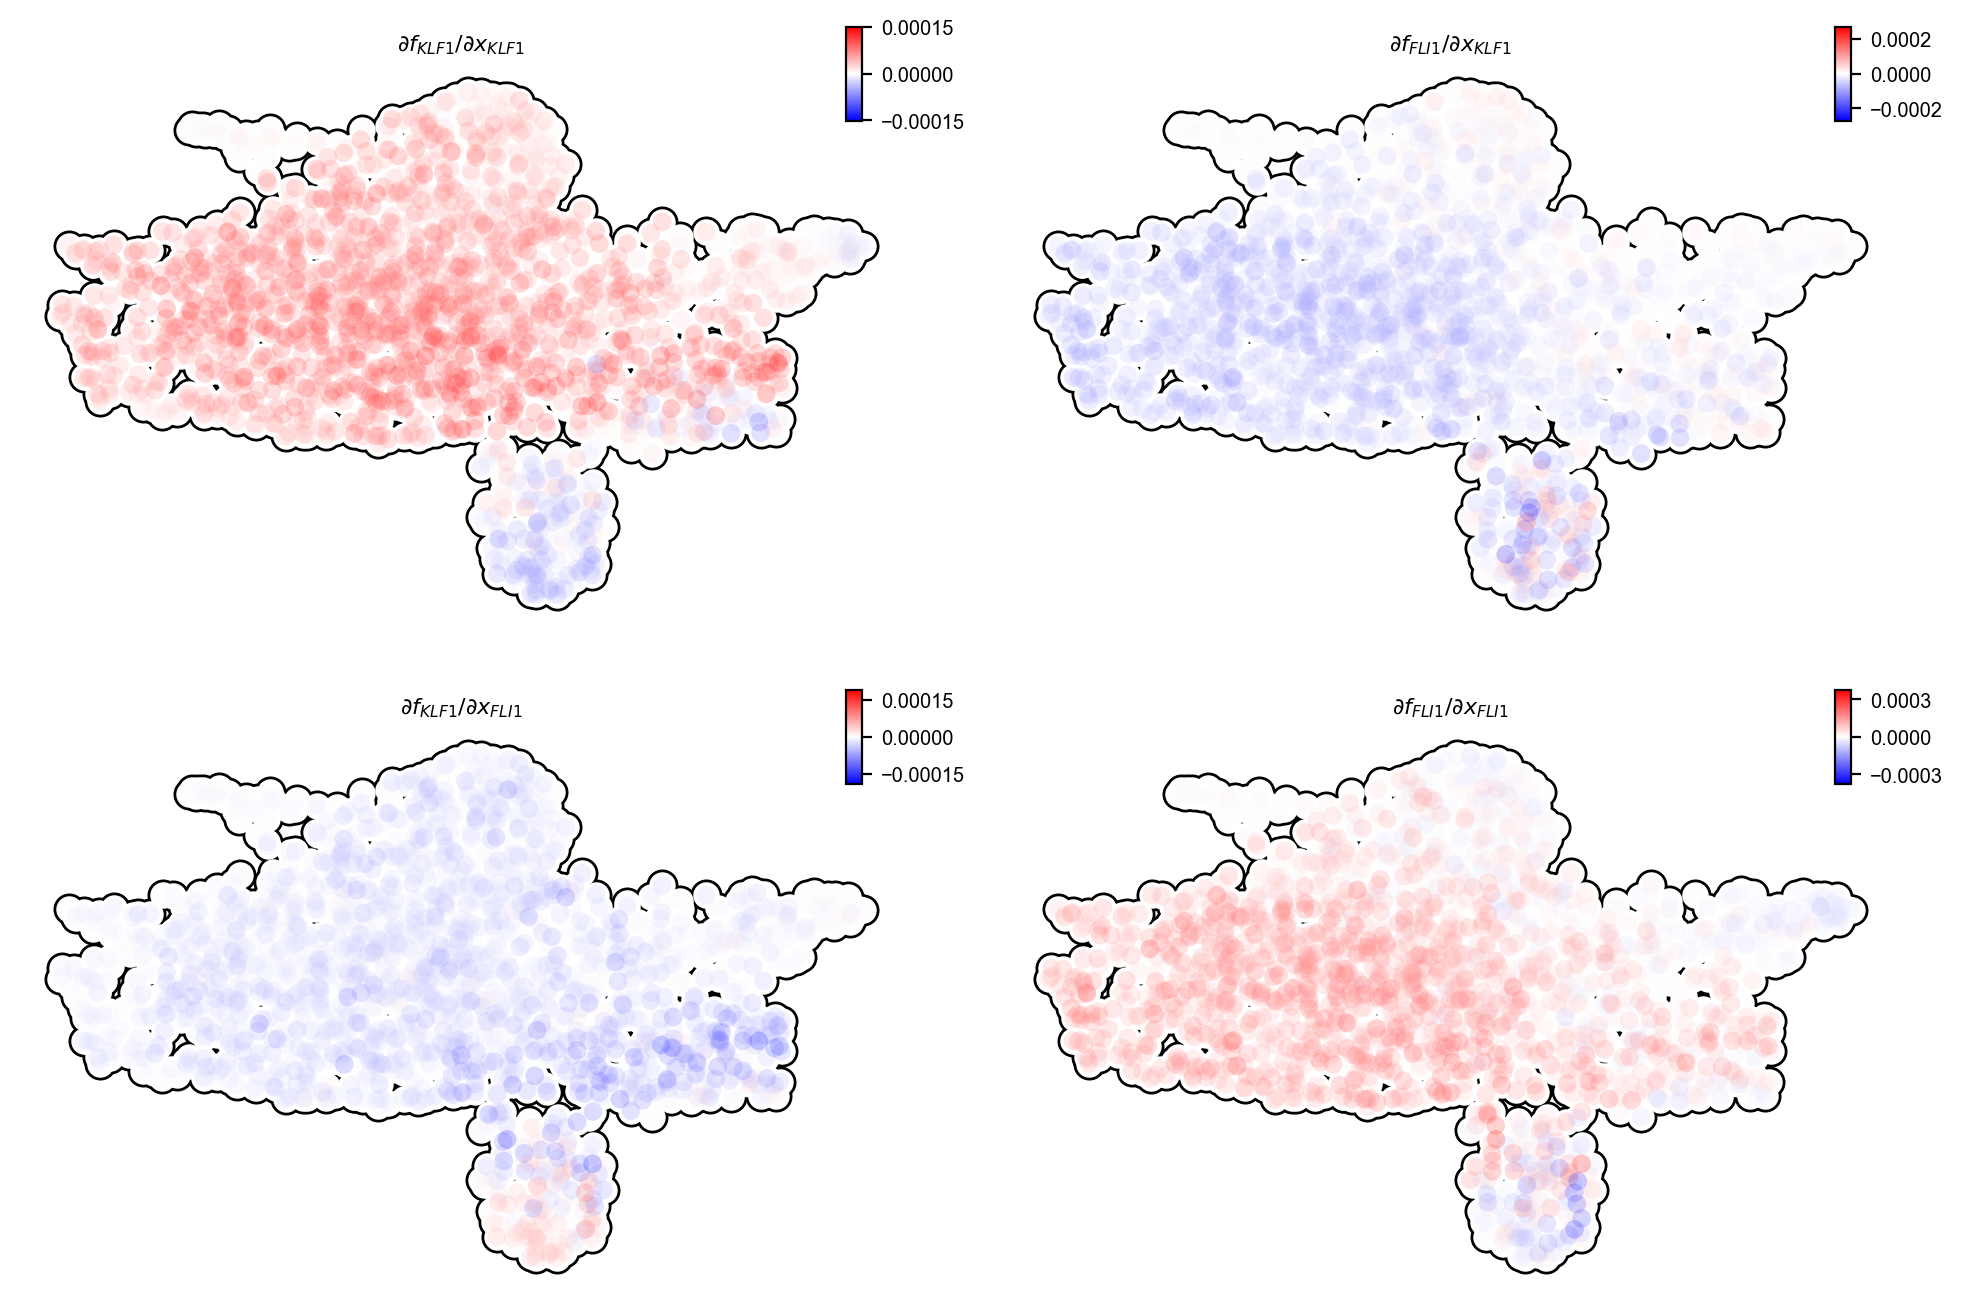

In [9]:
dyn.pl.jacobian(
    adata_labeling,
    regulators=Meg_genes,
    basis="umap",
)


## Regulatory network governing the Bas lineage’s dual origins

In this section, we will show

- GATA2 has high expression in the Bas lineage
- CEBPA represses RUNX1 and GATA2
- A minimal network governing GMP vs. Bas origin of Bas lineage

GATA2 has high expression in the Bas lineage

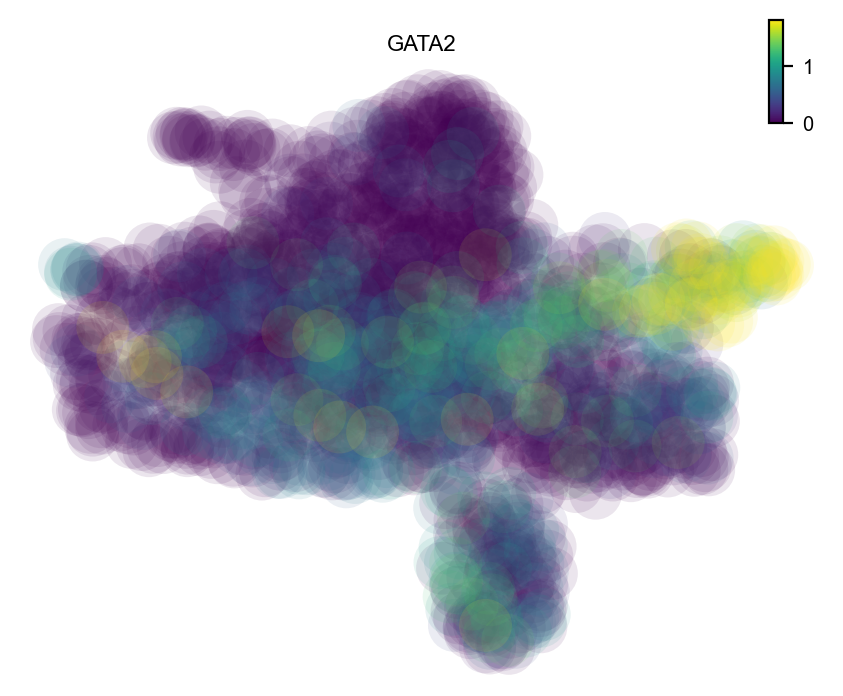

In [10]:
dyn.pl.scatters(adata_labeling, color="GATA2")


Next, we will calculate jacobian via `dyn.vf.jacobian` and then show that CEBPA represses RUNX1 and GATA2.

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 109198.62it/s]
/Users/random/dynamo-release/dynamo/plot/vector_calculus.py:658: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


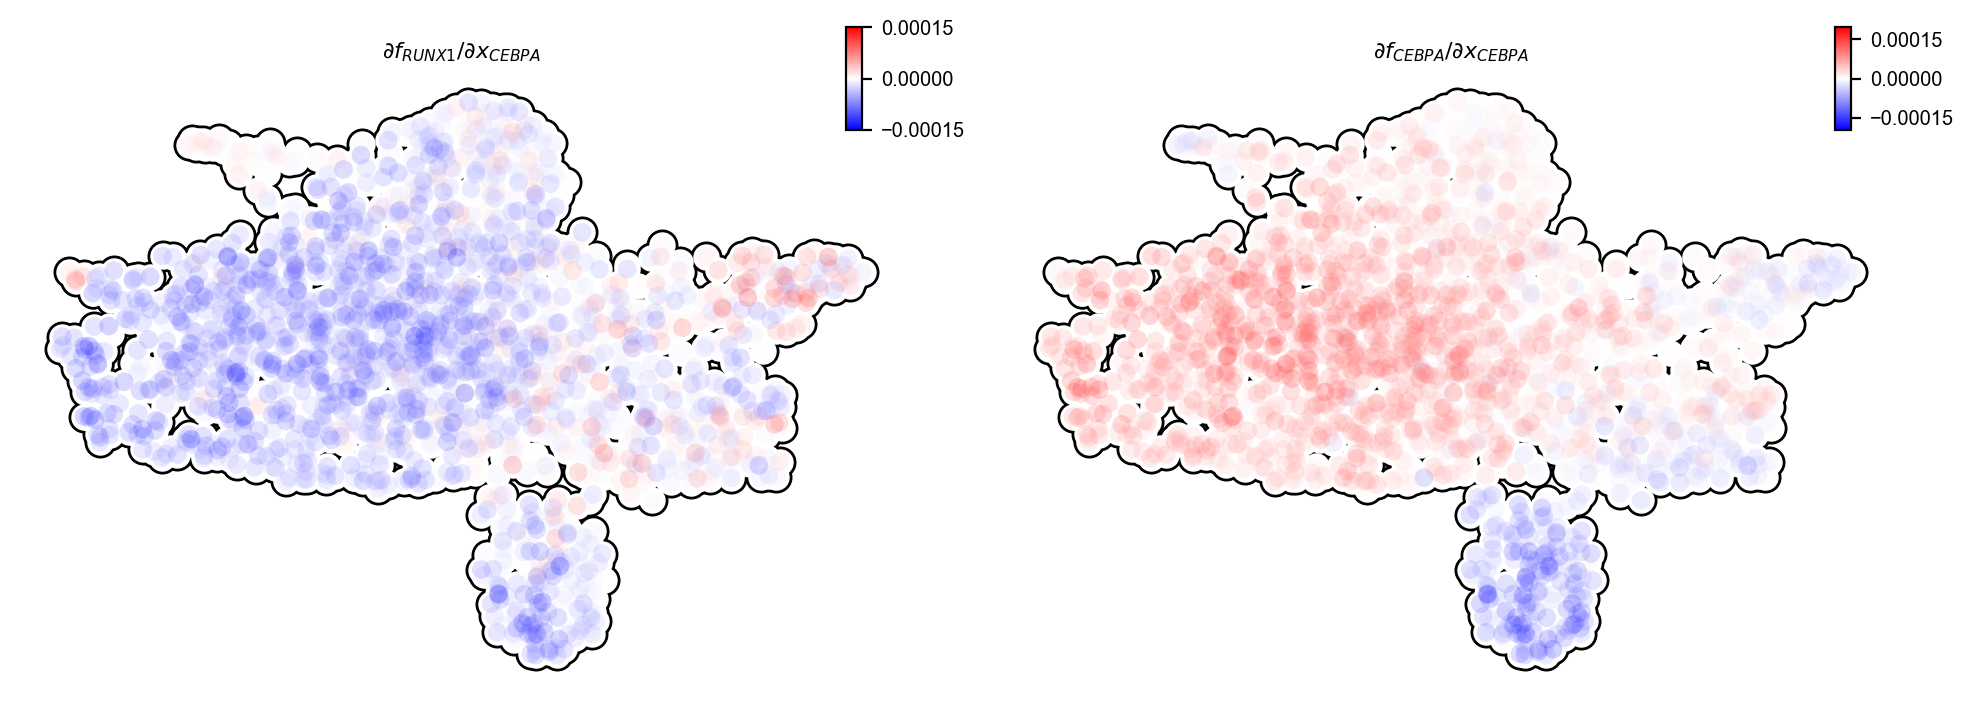

In [11]:
selected_genes = ["GATA2", "CEBPA", "RUNX1"]

dyn.vf.jacobian(adata_labeling, regulators=selected_genes, effectors=selected_genes)
dyn.pl.jacobian(
    adata_labeling,
    regulators="CEBPA",
    effectors=["RUNX1", "CEBPA"],
    basis="umap"
)


## Three approaches for in-depth network motif characterizations
The schematic graph in this section shows the three approaches.
- cell-wise analyses to reveal dominant interactions across all cells
- trajectory-wise analyses reveal trajectory dependent interactions along a trajectory (predicted either from vector field streamline, or least action path, see Figure 6). 
- Plane-wise analyses reveal direct interactions for any characteristic cell states by varying genes of interest while holding all other genes constant.

In the next section, we will use **cell-wise analyses** to analyze PU.1/SPI1–GATA1 network motif.  

![fig5_h](images/fig5_h.png)

## Cell-wise analyses of the PU.1/SPI1–GATA1 network motif across all cells

### Schematic of the SPI1-GATA1 toggle switch model

![fig5_I_i](images/fig5_I_i.png)

### Streamline plot of the RNA velocities of SPI1 (x-axis) and GATA1 (y-axis)

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/random/dynamo-release/dynamo/plot/scVectorField.py:1711: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


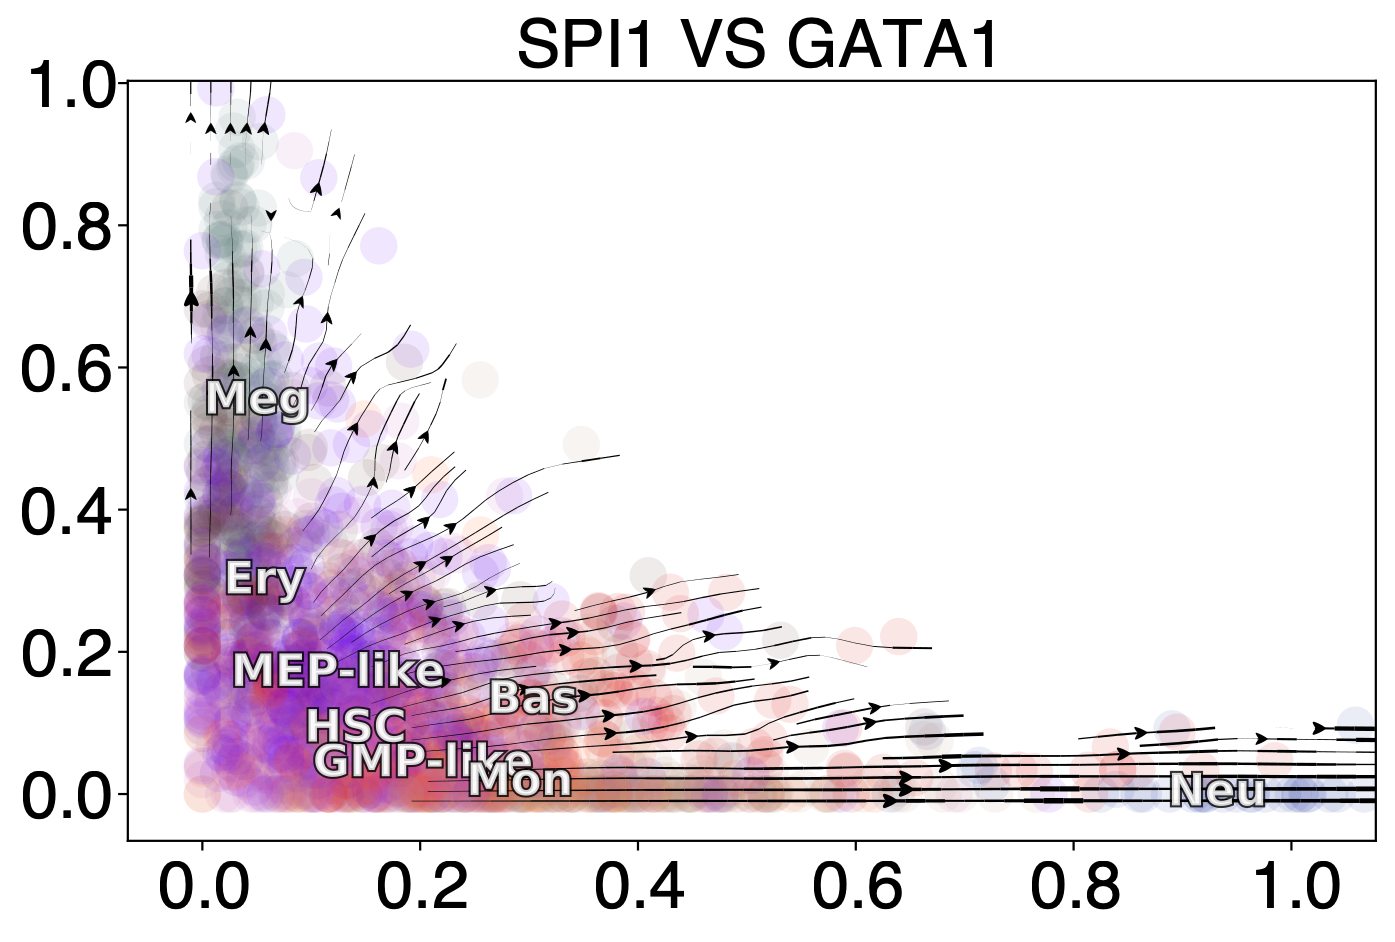

In [12]:
dyn.configuration.set_pub_style(scaler=4)
dyn.pl.streamline_plot(
    adata_labeling,
    color="cell_type",
    x="SPI1",
    y="GATA1",
    layer="M_t",
    ekey="M_t",
    pointsize=0.5,
    figsize=(8, 5),
    vkey="velocity_alpha_minus_gamma_s",
    s_kwargs_dict={"despline": False, "deaxis": False},
)


In [13]:
sum(adata_labeling.obs["pass_basic_filter"])

1947

In [14]:
adata_labeling.uns.keys()

dict_keys(['PCs', 'VecFld_pca', 'VecFld_umap', 'X_umap_neighbors', 'cell_phase_genes', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'grid_velocity_umap', 'grid_velocity_umap_ori_perturbation', 'grid_velocity_umap_test', 'jacobian_pca', 'leiden', 'neighbors', 'pca_mean', 'pp', 'response', 'SPI1 VS GATA1_colors'])

In [15]:
adata_labeling.uns["jacobian_pca"]['jacobian'].shape

(30, 30, 1947)

- Repression from SPI1 to GATA1, GATA1 to SPI1
- self-activation of SPI1, and GATA1, in the SPI1 and GATA1 expression space

In particular, the repression from SPI1 to GATA1 is mostly discernable in progenitors (rectangle A: bottom left) but becomes negligible when either GATA1 is much higher than SPI1 (rectangle B: upper left) or GATA1 is close to zero (rectangle C: bottom right).

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 151295.20it/s]
/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 162410.20it/s]
/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res

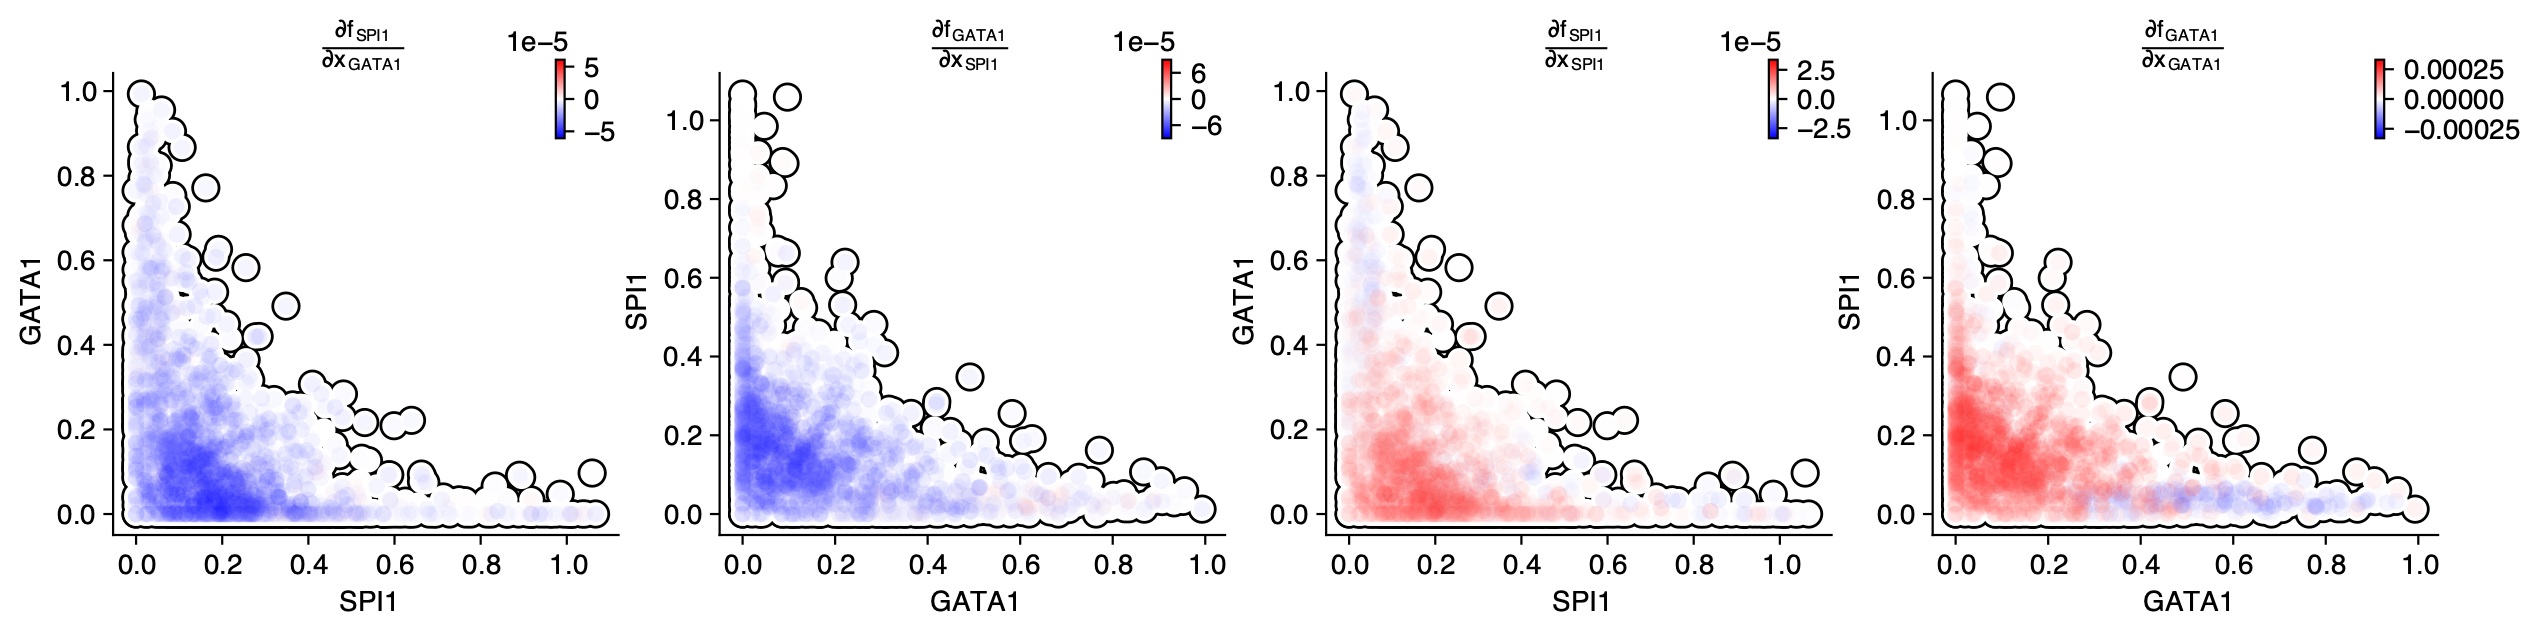

In [16]:
genes = ["SPI1", "GATA1"]
def plot_jacobian_on_gene_axis(receptor, effector, x_gene=None, y_gene=None, axis_layer="M_t", temp_color_key="temp_jacobian_color", ax=None):
    if x_gene is None:
        x_gene = receptor
    if y_gene is None:
        y_gene = effector

    x_axis = adata_labeling[:, x_gene].layers[axis_layer].A.flatten(),
    y_axis = adata_labeling[:, y_gene].layers[axis_layer].A.flatten(),

    dyn.vf.jacobian(adata_labeling, regulators = [receptor, effector], effectors=[receptor, effector])
    J_df = dyn.vf.get_jacobian(
        adata_labeling,
        receptor,
        effector,
    )

    color_values = np.full(adata_labeling.n_obs, fill_value=np.nan)
    color_values[adata_labeling.obs["pass_basic_filter"]] =  J_df.iloc[:, 0]
    adata_labeling.obs[temp_color_key] = color_values

    ax = dyn.pl.scatters(
        adata_labeling,
        vmin=0,
        vmax=100,
        color=temp_color_key,
        cmap="bwr",
        sym_c=True,
        frontier=True,
        sort="abs",
        alpha=0.1,
        pointsize=0.1,
        x=x_axis,
        y=y_axis,
        save_show_or_return="return",
        despline=True,
        despline_sides=["right", "top"],
        deaxis=False,
        ax=ax,
    )
    ax.set_title(r"$\frac{\partial f_{%s}}{\partial x_{%s}}$" % (effector, receptor))
    ax.set_xlabel(x_gene)
    ax.set_ylabel(y_gene)
    adata_labeling.obs.pop(temp_color_key)

figure, axes = plt.subplots(1, 4, figsize=(15, 3))
plot_jacobian_on_gene_axis("GATA1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[0])
plot_jacobian_on_gene_axis("SPI1", "GATA1", x_gene="GATA1", y_gene="SPI1", ax=axes[1])
plot_jacobian_on_gene_axis("SPI1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[2])
plot_jacobian_on_gene_axis("GATA1", "GATA1", x_gene="GATA1", y_gene="SPI1",ax=axes[3])
plt.show()


### Response heatmap
White dashed lines indicate the minimum or maximum of repression or activation and the corresponding expression threshold.

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 154023.20it/s]
/Users/random/dynamo-release/dynamo/plot/heatmaps.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h = np.array(rep(h, length=2))
/Users/random/dynamo-release/dynamo/plot/heatmaps.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

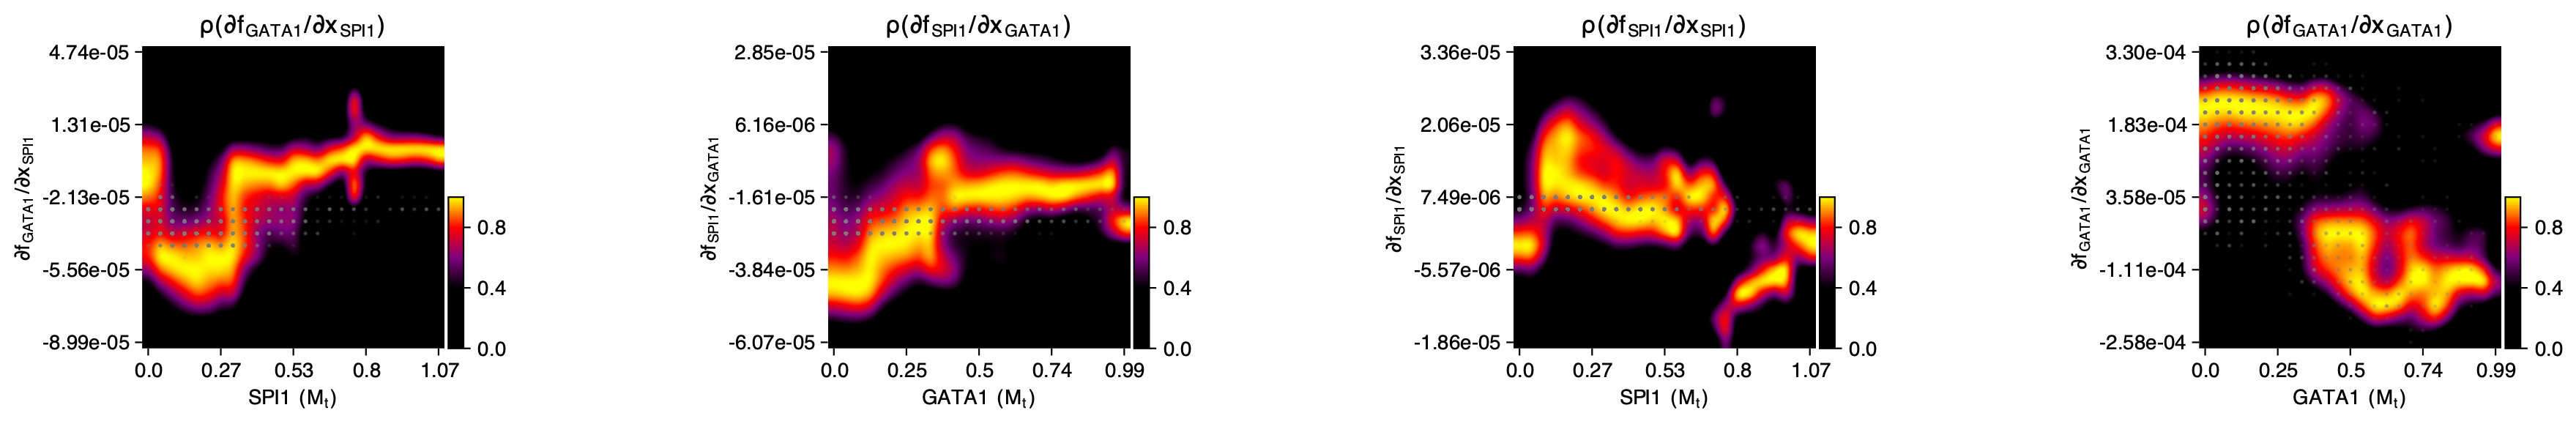

In [17]:
dyn.vf.jacobian(adata_labeling, regulators=["SPI1", "GATA1"], effectors=["SPI1", "GATA1"])

dyn.pl.response(
    adata_labeling,
    np.array([["SPI1", "GATA1"], ["GATA1", "SPI1"], ["SPI1", "SPI1"], ["GATA1", "GATA1"]]),
    ykey="jacobian",
    log=False,
    drop_zero_cells=True,
    grid_num=25,
    figsize=(5, 3),
    save_show_or_return="show"
)

In [18]:
dyn.cleanup(adata_labeling)
# adata_labeling.uns["response"] = None
# adata_labeling.write_h5ad("./data/debug_vf.h5ad")

dyn.vf.VectorField(adata_labeling, M=500, pot_curl_div=True, basis="umap")


|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [1.9452s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 1947/1947 [00:00<00:00, 22511.05it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 2/2 [00:00<00:00, 23.67it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [7.3192s]


## Visualize topography


### Lineage tree of hematopoiesis, lumped automatically from the vector field built in the UMAP space

![fig5_C](images/fig5_C.png)


### The reconstructed vector field and associated fixed points. 
The color of digits in each node reflects the type of fixed point: red, emitting fixed point; black, absorbing fixed point. The color of the numbered nodes corresponds to the confidence of the fixed points.

#### Manually select good fixed points found by topography.

In [19]:
adata_labeling.uns['VecFld_umap'].keys()

dict_keys(['X', 'valid_ind', 'X_ctrl', 'ctrl_idx', 'Y', 'beta', 'V', 'C', 'P', 'VFCIndex', 'sigma2', 'grid', 'grid_V', 'iteration', 'tecr_traj', 'E_traj', 'normalize', 'method', 'dims'])

In [20]:
dyn.vf.topography(adata_labeling, n=250, basis='umap')


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'cosine_potential', 'control_point_umap', 'inlier_prob_umap', 'o

In the resulted dictionary, `Xss` stands for the fixed points coordinates and `ftype` is the specific fixed point type, denoted by integers.  
ftype value mapping:  
-1: stable, 0: saddle, 1: unstable

In [22]:
Xss, ftype = adata_labeling.uns['VecFld_umap']['Xss'], adata_labeling.uns['VecFld_umap']['ftype']
good_fixed_points = [4, 1, 5, 7, 16, 26]
Xss[good_fixed_points], ftype[good_fixed_points]

adata_labeling.uns['VecFld_umap']['Xss'] = Xss[good_fixed_points]
adata_labeling.uns['VecFld_umap']['ftype'] = ftype[good_fixed_points]


/Users/random/dynamo-release/dynamo/plot/topography.py:537: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7ff6a0d45790>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/Users/random/dynamo-release/dynamo/plot/topography.py:1342: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


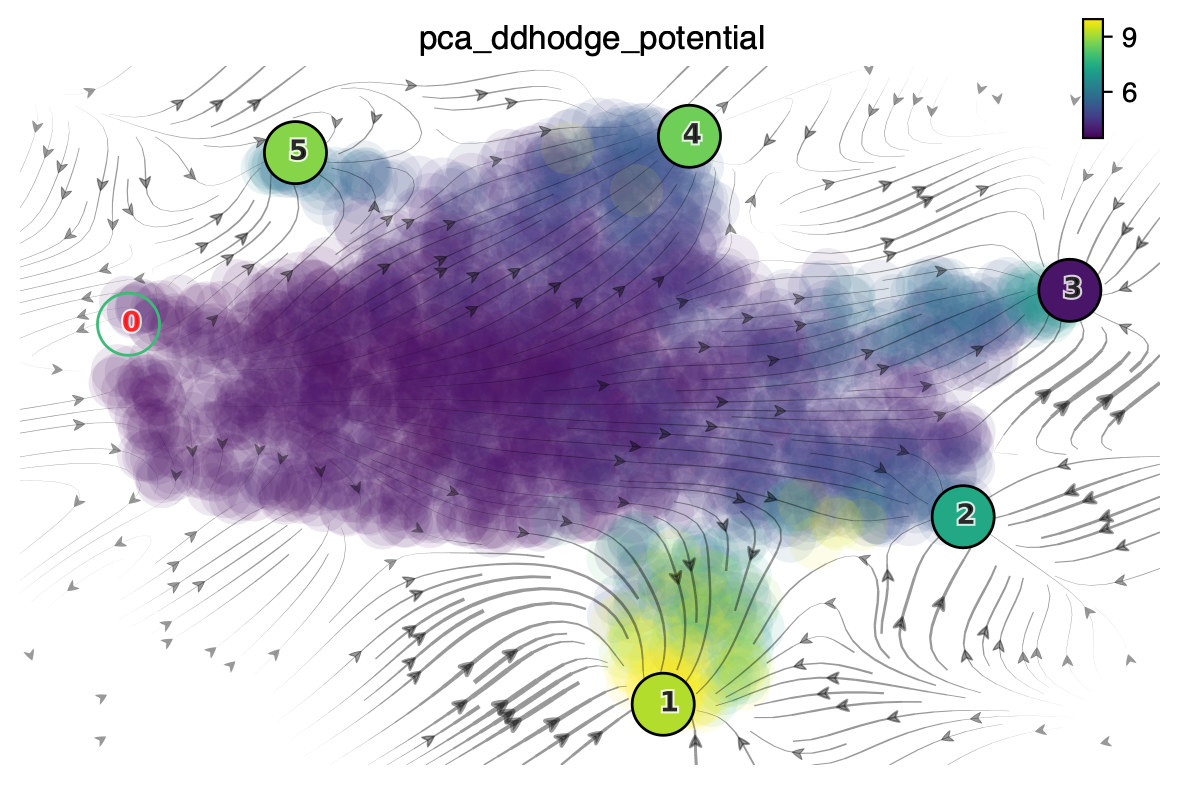

In [23]:
dyn.pl.topography(adata_labeling, 
                  markersize=500,
                  basis='umap', 
                  fps_basis='umap', 
                  color=['pca_ddhodge_potential'],)